In [1]:
import matplotlib.pyplot as plt
import json

from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

from pts.model.deepar import DeepAREstimator
from pts.modules.distribution_output import ImplicitQuantileOutput
from pts import Trainer
from pts.dataset.repository.datasets import dataset_recipes

In [2]:
import torch

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
dataset = get_dataset("m5", regenerate=False)

In [5]:
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Recommended prediction horizon: 28
Frequency of the time series: D


In [6]:
estimator = DeepAREstimator(
    distr_output=ImplicitQuantileOutput(output_domain="Positive"),
    cell_type='GRU',
    input_size=62,
    num_cells=64,
    num_layers=3,
    dropout_rate=0.2,
    use_feat_dynamic_real=True,
    use_feat_static_cat=True,
    cardinality=[int(cat_feat_info.cardinality) for cat_feat_info in dataset.metadata.feat_static_cat],
    embedding_dimension = [4, 4, 4, 4, 16],
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*2,
    freq=dataset.metadata.freq,
    scaling=True,
    trainer=Trainer(device=device,
                    epochs=20,
                    learning_rate=1e-3,
                    num_batches_per_epoch=120,
                    batch_size=256,
                   )
)

In [7]:
predictor = estimator.train(dataset.train, num_workers=8)

255it [00:12, 20.38it/s]
0it [00:00, ?it/s]/usr/local/anaconda3/lib/python3.8/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'pts.distributions.implicit_quantile.ImplicitQuantile'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +
0it [00:03, ?it/s, avg_epoch_loss=0.499, epoch=0]
255it [00:12, 20.62it/s]
0it [00:03, ?it/s, avg_epoch_loss=0.373, epoch=1]
255it [00:12, 20.47it/s]
0it [00:03, ?it/s, avg_epoch_loss=0.356, epoch=2]
255it [00:12, 20.37it/s]
0it [00:03, ?it/s, avg_epoch_loss=0.349, epoch=3]
255it [00:12, 20.32it/s]
0it [00:03, ?it/s, avg_epoch_loss=0.344, epoch=4]
255it [00:12, 20.27it/s]
0it [00:03, ?it/s, avg_epoch_loss=0.342, epoch=5]
255it [00:12, 20.35it/s]
0it [00:03, ?it/s, avg_epoch_loss=0.34, epoch=6]
255it [00:12, 20.70it/s]
0it [00:03, ?it/s, avg_epoch_loss=0.339, ep

In [8]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [9]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [10]:
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 30490/30490 [00:01<00:00, 27259.18it/s]
/home/krasul/.env/pytorch/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1672: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(values, dtype=dtype, copy=copy)


In [11]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 4.755984111358613,
    "abs_error": 834177.9219083469,
    "abs_target_sum": 1231764.0,
    "abs_target_mean": 1.4428196598416543,
    "seasonal_error": 1.12721783493784,
    "MASE": 0.8981968607451877,
    "MAPE": 0.8099336448562378,
    "sMAPE": 1.6020707415533486,
    "OWA": NaN,
    "MSIS": 8.260408136542406,
    "QuantileLoss[0.1]": 232933.92667773535,
    "Coverage[0.1]": 0.5482148713864025,
    "QuantileLoss[0.2]": 432863.72900996683,
    "Coverage[0.2]": 0.5567293726280275,
    "QuantileLoss[0.3]": 602256.93819869,
    "Coverage[0.3]": 0.5704551843695826,
    "QuantileLoss[0.4]": 737814.7064298784,
    "Coverage[0.4]": 0.5920418872698383,
    "QuantileLoss[0.5]": 834177.922027275,
    "Coverage[0.5]": 0.6226373986787334,
    "QuantileLoss[0.6]": 884780.6868602519,
    "Coverage[0.6]": 0.6591399990629399,
    "QuantileLoss[0.7]": 876329.6622192905,
    "Coverage[0.7]": 0.7127079136016631,
    "QuantileLoss[0.8]": 791094.1399574431,
    "Coverage[0.8]": 0.78173874338

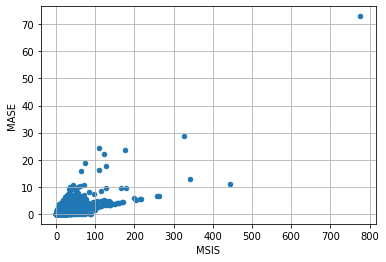

In [12]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()